## Mask Detector - Detecting 3 classes using YOLOv8 - mAP0.5 > 0.94


## YOLO - You Only Look Once 

YOLO belongs to the ultralytic framework. An open-source hub specialized in object detection, segmentation, real-time detection, tracking and pose-analysis.

We need to prepare the dataset. In our case, we will use a dataset available in Kaggle ([Kaggle dataset](https://www.kaggle.com/andrewmvd/face-mask-detection)). In my case, since I am working remotely, I am downloading the dataset. The dataset is composed by 2 folders, `images` and `annotations`.  The annotations are in XML format, and YOLOv8 works with `.txt` format so we need to conver this file to `.txt`


### Tranform XML to YOLO .txt format

YOLO expects `.txt` files in the followign format:

`<class_id> <x_center_normalized> <y_center_normalized> <width_normalized> <height_normalized>`

If a bounding box is located in: `(xmin=103, ymin=88, xmax=194, ymax=128)`, in YOLO format it is:
`0 0.2297 0.2250 0.1422 0.0833`

Note that the first "0" means the class_id assigned to that box. And there could be more than one box per image

Also YOLO offers an easy way to format annotations, using [Labelformat](https://labelformat.com/). For the sake of training, we will create our tools for that.

Let's convert to `.txt` format our annotations using our `xml_to_yolo.py` module

In [2]:
from src.xml_to_yolo import *
from pathlib import Path

ds_path = Path("dataset") 

#Define classes that are inside the xml files
classes = {"without_mask": 0, "with_mask": 1, "mask_weared_incorrect": 2}
annotations_dir = ds_path/"labels"
output_dir = annotations_dir  # You can change this to a different folder if preferred

#Create the annotations files in txt in the same directory
convert_annotations_to_yolo(annotations_dir=annotations_dir, classes=classes, output_dir=output_dir)

This will create the `.txt` files in the same original annot folder


### Simple EDA: understanding our class distribution

Let's use the the `.txt`file structure to count the number of clases in the whole image set amd plot the distribution for visual understanding

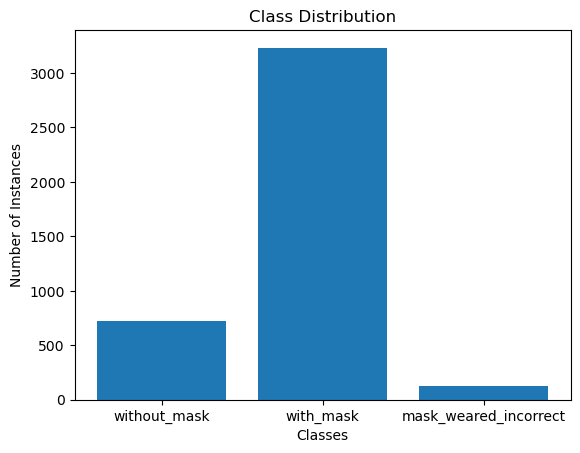

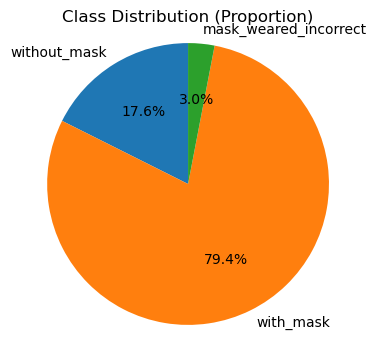

In [3]:
from src.visualization import *

class_count = count_classes_from_txt_files(ds_path/"labels", classes)
plot_class_distribution(class_count)

As we can see, we have a clear imbalance of classes. And in order to not bias our model, we should stratify the train and val set in the same proportion. There are several ways to do that, in my case I will use an approach that groups images per minority class, force the inclusion of such images in the train and val, and the rest is divided in train and val. Important to note is that we are not balancing instance-wise, no, we are balancing by if an images has a minority class and dividing this groups of minority images 80% and 20%.


In [4]:
from src.data_handling import *

annotations_dir = ds_path/"labels"
image_dir = ds_path/"images"
stratified_output = ds_path/"stratified_dataset"
tr_ratio = 0.8
val_ratio = 0.2
train_split, val_split  = [], []

#Identify minority images (without mask (0) and weared incorrect (2))
#This returns a dict with keys as class and values with image names
minority_classes = [0, 2]
minority_images = identify_minority_images(annotations_dir, minority_classes)
#Since its possible that an image has both no mask and mask weared incorrect, images may be in both list
repeated_images = get_repeated_images(minority_images)
#When we split them, it can cause data leakage. We have to handle that data leakage
#The handle_data_leakage deletes dupplicates and return minority without them, and the repeated ones are shared on the splits
minority_images, train_shared, val_shared = handle_data_leakage(minority_images, repeated_images, tr_ratio, val_ratio)
#Lets create a list with all te majority images excluding the minoritiy
all_images = [file.replace(".txt", ".png") for file in os.listdir(ds_path/"labels") if file.endswith(".txt")]
#Delete the minority images + repeated from it (transform minority image into a set) using set reduction
majority_imgages = list(set(all_images) - set(elem for value in minority_images.values() for elem in value) - set(repeated_images)) 
#Split majority according to ratios
train_majority, val_majority = split_images(majority_imgages, tr_ratio, val_ratio)

#Append all the different shares from minority, majority and repeated
#Split minority image dictionary into the train and val splits
for cls_id, image_list in minority_images.items():
        train_set, val_set = split_images(image_list, tr_ratio, val_ratio)
        train_split.extend(train_set)
        val_split.extend(val_set)
#Append the repeated images to each split from repeated and majority
train_split.extend(train_shared)
val_split.extend(val_shared)
train_split.extend(train_majority)
val_split.extend(val_majority)



Now the last part is to create the stratified directories according to our stratified analysis we have done. Since YOLO is able to read like this:
```bash
dataset/
├── data.yaml
├── train/
│   ├── images/
│   │   ├── image1.jpg
│   │   └── image2.jpg
│   └── labels/
│       ├── image1.txt
│       └── image2.txt
└── val/
    ├── images/
    │   ├── image3.jpg
    │   └── image4.jpg
    └── labels/
        ├── image3.txt
        └── image4.txt
```

We will just create the train and val folder and put images and labels together as YOLO wants

In [5]:
#Crate dirs and copy files
output_stratified = ds_path/"_stratified_dataset"
images_dir = ds_path/"images"

train_dir = os.path.join(output_stratified, "train")
val_dir = os.path.join(output_stratified, "val")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
copy_files(train_split, train_dir, images_dir, annotations_dir)
copy_files(val_split, val_dir, images_dir, annotations_dir)

Nice! we have done it. Now we have our own stratified dataset in train and val splits. This is important as a random split could lead to a huge bias (imagine having val dataset without a single image of mask weared incorrect)

Moreover, let's check that the total instances remain the same as our distribution graph using our `plot_class_distribution` function

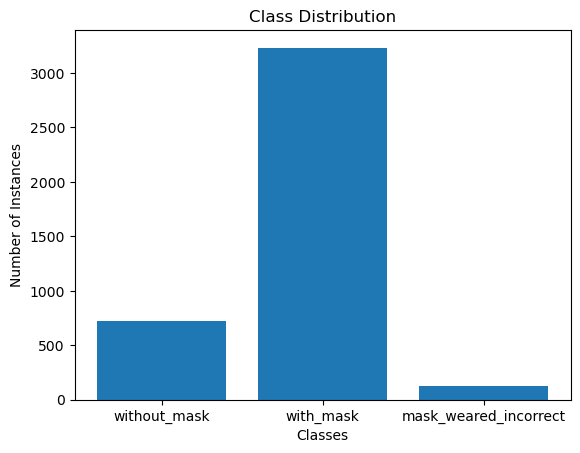

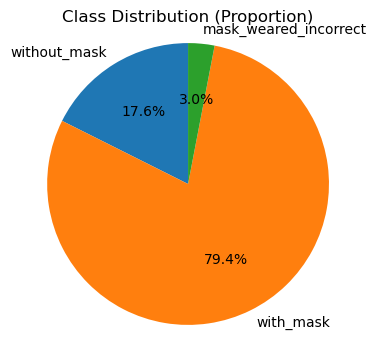

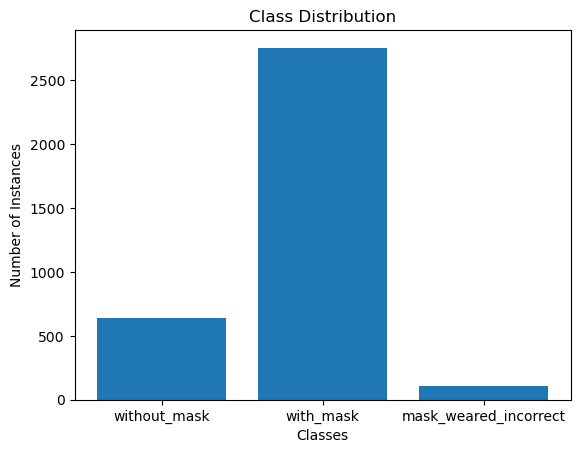

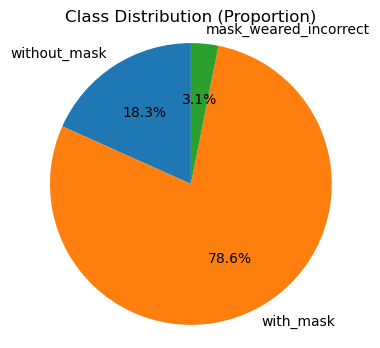

In [6]:
plot_class_distribution(count_classes_from_txt_files(output_stratified/"train", classes)), 
plot_class_distribution(count_classes_from_txt_files(output_stratified/"val", classes))

As we can see, our dataset has been splitted mantaining the stratification of classes. As we explained before, it is not a **PERFECT** stratification due to the fact that we are dividing image-wise, not instance-wise but definetly is way better than having a random split.

### Create a yaml file for YOLO models

YOLOv11 model uses a yaml file to understand where are the folders with training, val and its notations. It is a simple file that I created by modifying a ".txt" file and changed the extension to ".yaml". The information inside is:

    path: /absolute/route/to/dataset
    train: train/images
    val: val/images

    names:
     0: with_mask
     1: without_mask
     2: mask_weared_incorrect



In [7]:
yaml_file_path = "dataset_config.yaml"

# yaml file content
data = """
path: "/home/edu_pc/Projects/Mask_detector_3classes/dataset/_stratified_dataset"
train: "train"
val: "val"

names:
  0: without_mask
  1: with_mask
  2: mask_weared_incorrect
"""

# .yaml creation
with open(yaml_file_path, "w") as file:
    file.write(data)

print(f".yaml file created in:{yaml_file_path}")

.yaml file created in:dataset_config.yaml


## Train the model using the stratified dataset

In [ ]:
#!pip install ultralytics
from ultralytics import YOLO

#Load the base model
model = YOLO("yolo11s.pt") #s from small version, you can still go lower and faster using the "n" version,

#Fine-tune
results = model.train(
    data="dataset_config.yaml",
    epochs=60,
    imgsz=400,
    batch=8,
    device="cuda",
    patience=5
)

Ultralytics 8.3.101 🚀 Python-3.11.11 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 2080 SUPER, 8192MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=dataset_config.yaml, epochs=60, time=None, patience=5, batch=8, imgsz=400, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

train: Scanning /home/edu_pc/Projects/Mask_detector_3classes/dataset/_stratified_dataset/train.cache... 853 images, 0 backgrounds, 0 corrupt: 100%|██████████| 853/853 [00:00<?, ?it/s]
val: Scanning /home/edu_pc/Projects/Mask_detector_3classes/dataset/_stratified_dataset/val.cache... 712 images, 0 backgrounds, 0 corrupt: 100%|██████████| 712/712 [00:00<?, ?it/s]
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to runs/detect/train2
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      1.07G      2.793      4.504       2.09         50        416:   7%|▋         | 8/107 [00:01<00:12,  8.04it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       1/60      1.18G      1.568       1.67      1.197         29        416: 100%|██████████| 107/107 [00:09<00:00, 11.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:03<00:00, 10.03it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:04<00:00,  9.81it/s]

                   all        712       3504      0.475      0.489      0.512       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/107 [00:00<?, ?it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       2/60      1.44G       1.28     0.9327      1.024         85        416: 100%|██████████| 107/107 [00:09<00:00, 11.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:03<00:00,  9.58it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:04<00:00, 10.14it/s]

                   all        712       3504      0.565      0.523      0.551      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      1.44G      1.307      0.879      1.066         52        416:   1%|          | 1/107 [00:00<00:11,  9.44it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       3/60      1.44G      1.241     0.8611          1         45        416: 100%|██████████| 107/107 [00:08<00:00, 12.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 10.88it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:04<00:00, 10.68it/s]

                   all        712       3504      0.732      0.548      0.613      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      1.44G      1.245      0.854      1.022         62        416:  68%|██████▊   | 73/107 [00:06<00:02, 11.91it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       4/60      1.44G       1.24     0.8413      1.021         37        416: 100%|██████████| 107/107 [00:09<00:00, 11.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 11.05it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:04<00:00, 11.02it/s]

                   all        712       3504      0.781      0.635      0.711       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      1.44G      1.274     0.8016     0.9947         63        416:   1%|          | 1/107 [00:00<00:11,  9.31it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       5/60      1.44G      1.249     0.8107      0.994         37        416: 100%|██████████| 107/107 [00:09<00:00, 11.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:02<00:00, 21.43it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:02<00:00, 15.62it/s]

                   all        712       3504      0.806      0.676      0.755      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      1.44G      1.138     0.7926      1.014         54        416:  10%|█         | 11/107 [00:00<00:07, 12.03it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       6/60      1.44G      1.156     0.7712     0.9944         17        416: 100%|██████████| 107/107 [00:09<00:00, 11.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 11.24it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 11.41it/s]

                   all        712       3504      0.741      0.678      0.731      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      1.44G      1.182     0.7939      1.006         70        416:  39%|███▉      | 42/107 [00:03<00:05, 12.57it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       7/60      1.44G      1.187     0.7775     0.9958         61        416: 100%|██████████| 107/107 [00:08<00:00, 11.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 11.21it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 11.27it/s]

                   all        712       3504      0.768      0.723      0.769      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      1.44G      1.201     0.7435       0.99         88        416:   7%|▋         | 8/107 [00:00<00:07, 12.43it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       8/60      1.44G      1.165     0.7354     0.9718         33        416: 100%|██████████| 107/107 [00:07<00:00, 14.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 10.71it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:04<00:00, 10.90it/s]

                   all        712       3504      0.798      0.685      0.759      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      1.44G      1.199     0.7444     0.9926         25        416:  19%|█▊        | 20/107 [00:01<00:07, 12.39it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
       9/60      1.44G      1.152     0.7356     0.9773         43        416: 100%|██████████| 107/107 [00:08<00:00, 11.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:03<00:00, 10.04it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:04<00:00, 10.41it/s]


                   all        712       3504       0.83      0.691      0.771       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      1.44G      1.124      0.747     0.9838        100        416:  79%|███████▊  | 84/107 [00:07<00:01, 11.55it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      10/60      1.44G      1.135     0.7412       0.98         31        416: 100%|██████████| 107/107 [00:07<00:00, 13.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 11.48it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 11.77it/s]

                   all        712       3504      0.891      0.699      0.805       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      1.44G      1.143      0.683     0.9643         60        416:  67%|██████▋   | 72/107 [00:05<00:02, 12.00it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      11/60      1.44G      1.142     0.6868     0.9719         83        416: 100%|██████████| 107/107 [00:08<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 11.02it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:04<00:00, 11.24it/s]

                   all        712       3504      0.848      0.707      0.792      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      1.44G      1.121     0.6851     0.9595         47        416:  82%|████████▏ | 88/107 [00:07<00:01, 12.83it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      12/60      1.44G      1.121     0.6895     0.9615         38        416: 100%|██████████| 107/107 [00:08<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00,  9.41it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:04<00:00, 10.03it/s]

                   all        712       3504      0.849       0.71      0.802      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      1.44G     0.9947     0.7093      1.019         35        416:   0%|          | 0/107 [00:00<?, ?it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      13/60      1.44G      1.096     0.6736     0.9638         28        416: 100%|██████████| 107/107 [00:07<00:00, 14.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:03<00:00,  9.87it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:04<00:00, 10.54it/s]

                   all        712       3504      0.842      0.713      0.804       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      1.44G      1.096     0.6446     0.9562         94        416:  45%|████▍     | 48/107 [00:03<00:04, 12.95it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      14/60      1.44G      1.109     0.6503     0.9517         24        416: 100%|██████████| 107/107 [00:08<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 11.45it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 11.83it/s]

                   all        712       3504      0.875      0.735      0.821       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      1.44G       1.09     0.6516     0.9553         53        416:  67%|██████▋   | 72/107 [00:05<00:02, 13.11it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      15/60      1.44G      1.093     0.6472     0.9594         11        416: 100%|██████████| 107/107 [00:07<00:00, 15.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 11.66it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 11.84it/s]

                   all        712       3504      0.875        0.7      0.817      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      1.44G      1.066     0.6488     0.9483        174        416:  29%|██▉       | 31/107 [00:02<00:05, 13.12it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      16/60      1.44G      1.068     0.6358     0.9461         50        416:  93%|█████████▎| 99/107 [00:07<00:00, 12.94it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      16/60      1.44G      1.068     0.6352     0.9461         68        416: 100%|██████████| 107/107 [00:08<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 11.57it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 11.66it/s]

                   all        712       3504      0.891      0.748      0.842      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      1.44G      1.083     0.6314     0.9534         38        416:  93%|█████████▎| 100/107 [00:07<00:00, 13.23it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      17/60      1.44G       1.08     0.6316     0.9522         62        416: 100%|██████████| 107/107 [00:08<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:02<00:00, 11.90it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 12.23it/s]

                   all        712       3504      0.861      0.777      0.844      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      1.44G      1.063     0.6246     0.9479         69        416: 100%|██████████| 107/107 [00:07<00:00, 13.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:04<00:00,  8.86it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:04<00:00,  9.11it/s]

                   all        712       3504       0.89       0.78      0.862      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      1.44G      1.086     0.6288     0.9525        100        416:  43%|████▎     | 46/107 [00:03<00:04, 12.66it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      19/60      1.44G      1.072     0.6262     0.9452         11        416: 100%|██████████| 107/107 [00:08<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 11.15it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 11.57it/s]

                   all        712       3504      0.855      0.786      0.852      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      1.44G      1.058      0.609     0.9305         71        416:  21%|██        | 22/107 [00:01<00:07, 11.90it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      20/60      1.44G      1.051     0.6047     0.9359         32        416: 100%|██████████| 107/107 [00:07<00:00, 13.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:04<00:01,  8.92it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:04<00:00,  9.09it/s]

                   all        712       3504      0.878      0.784      0.852      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      1.44G      1.037      0.596     0.9395        133        416:  70%|███████   | 75/107 [00:06<00:02, 11.85it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      21/60      1.44G      1.037     0.5954     0.9383         31        416: 100%|██████████| 107/107 [00:08<00:00, 11.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 11.16it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 11.30it/s]

                   all        712       3504       0.93       0.77      0.877      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      1.44G       1.05     0.6082     0.9411         49        416:  39%|███▉      | 42/107 [00:03<00:05, 10.93it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      22/60      1.44G       1.05     0.6037     0.9351         23        416: 100%|██████████| 107/107 [00:09<00:00, 11.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:02<00:00, 21.64it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 14.16it/s]

                   all        712       3504      0.934      0.787      0.882      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      1.44G      1.026     0.5908     0.9277         60        416:  62%|██████▏   | 66/107 [00:06<00:03, 11.58it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      23/60      1.44G      1.034     0.5923     0.9311        149        416: 100%|██████████| 107/107 [00:09<00:00, 11.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 11.60it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 11.75it/s]

                   all        712       3504      0.905      0.815      0.888      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      1.44G      1.016     0.5675     0.9207        173        416:  26%|██▌       | 28/107 [00:02<00:06, 11.63it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      24/60      1.44G      1.016     0.5666     0.9264        131        416:  88%|████████▊ | 94/107 [00:07<00:01, 12.58it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      24/60      1.44G      1.021     0.5709     0.9293         30        416: 100%|██████████| 107/107 [00:08<00:00, 12.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 10.63it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:04<00:00, 11.11it/s]

                   all        712       3504      0.908      0.788      0.855      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      1.44G      1.032     0.5813     0.9386         38        416: 100%|██████████| 107/107 [00:07<00:00, 13.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:03<00:00, 10.54it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:04<00:00, 10.30it/s]

                   all        712       3504      0.902      0.811      0.884      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      1.44G     0.9649     0.5613     0.9063         63        416:   6%|▌         | 6/107 [00:00<00:07, 12.69it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      26/60      1.44G      1.005      0.561     0.9284         34        416: 100%|██████████| 107/107 [00:09<00:00, 11.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:03<00:00, 10.44it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 11.38it/s]

                   all        712       3504      0.891      0.829      0.887      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      1.44G      1.026     0.5713     0.9277         62        416:  65%|██████▌   | 70/107 [00:05<00:03, 10.93it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      27/60      1.44G      1.024     0.5733     0.9292         31        416:  86%|████████▌ | 92/107 [00:07<00:01, 11.41it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      27/60      1.44G      1.023     0.5741     0.9293         45        416: 100%|██████████| 107/107 [00:08<00:00, 13.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 11.17it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 11.31it/s]

                   all        712       3504      0.935      0.812      0.887      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      1.44G     0.9912     0.5476     0.9241         41        416:  86%|████████▌ | 92/107 [00:07<00:01, 12.23it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      28/60      1.44G     0.9953      0.551     0.9228         91        416: 100%|██████████| 107/107 [00:08<00:00, 12.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 11.05it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 11.38it/s]

                   all        712       3504       0.91      0.834      0.899      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      1.44G      1.012     0.5571     0.9278         39        416: 100%|██████████| 107/107 [00:08<00:00, 12.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 11.33it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 11.43it/s]

                   all        712       3504      0.948      0.809      0.901      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      1.44G       0.98     0.5216     0.9347         71        416:  41%|████      | 44/107 [00:02<00:04, 13.97it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      30/60      1.44G      1.002     0.5485     0.9276         43        416: 100%|██████████| 107/107 [00:08<00:00, 13.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00,  9.87it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:04<00:00,  9.82it/s]

                   all        712       3504      0.922      0.829      0.894      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      1.44G      1.017     0.5487      0.919        100        416:  15%|█▍        | 16/107 [00:01<00:07, 11.46it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      31/60      1.44G     0.9993     0.5425     0.9153         15        416: 100%|██████████| 107/107 [00:09<00:00, 11.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:03<00:00,  9.94it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:04<00:00, 10.23it/s]

                   all        712       3504      0.934      0.843      0.905      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      1.44G      1.006      0.549     0.9195         51        416:  83%|████████▎ | 89/107 [00:06<00:01, 14.25it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      32/60      1.44G      1.007     0.5497     0.9238         31        416: 100%|██████████| 107/107 [00:07<00:00, 14.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 10.99it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 11.36it/s]

                   all        712       3504      0.937      0.827      0.902      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      1.44G      0.982     0.5584     0.9408         40        416:  28%|██▊       | 30/107 [00:02<00:06, 11.98it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      33/60      1.44G     0.9787     0.5391     0.9289         64        416: 100%|██████████| 107/107 [00:08<00:00, 12.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 10.92it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 11.34it/s]

                   all        712       3504      0.946       0.83      0.913      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      1.44G     0.9266      0.538     0.9138         48        416:  11%|█         | 12/107 [00:01<00:08, 11.69it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      34/60      1.44G     0.9816     0.5279     0.9184         38        416: 100%|██████████| 107/107 [00:08<00:00, 12.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:02<00:00, 14.22it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 13.67it/s]

                   all        712       3504      0.946      0.846       0.91      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      1.44G     0.9681     0.5217     0.9184         61        416:  52%|█████▏    | 56/107 [00:04<00:04, 12.10it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      35/60      1.44G     0.9851     0.5313     0.9152         45        416: 100%|██████████| 107/107 [00:08<00:00, 12.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:03<00:00, 11.45it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 11.28it/s]

                   all        712       3504       0.94      0.837      0.913      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      1.44G     0.9661     0.5178     0.9186         47        416:  34%|███▎      | 36/107 [00:03<00:06, 11.32it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      36/60      1.44G     0.9572     0.5185     0.9159         25        416: 100%|██████████| 107/107 [00:09<00:00, 11.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 11.48it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 11.55it/s]

                   all        712       3504      0.933      0.829      0.903      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      1.44G      0.969     0.5173     0.9034         84        416:  73%|███████▎  | 78/107 [00:05<00:02, 11.93it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      37/60      1.44G     0.9554     0.5115     0.9019         52        416: 100%|██████████| 107/107 [00:07<00:00, 14.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 11.08it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:04<00:00, 10.96it/s]

                   all        712       3504      0.921      0.858      0.918       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      1.44G     0.9293     0.4811     0.9228         40        416:   7%|▋         | 8/107 [00:00<00:07, 12.65it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      38/60      1.44G     0.9504     0.5043     0.9135         77        416:  97%|█████████▋| 104/107 [00:08<00:00, 12.67it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      38/60      1.44G     0.9497     0.5041     0.9126         34        416: 100%|██████████| 107/107 [00:08<00:00, 12.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 11.17it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 11.39it/s]

                   all        712       3504      0.933      0.834      0.911      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      1.44G     0.9556     0.5095     0.9096         10        416: 100%|██████████| 107/107 [00:07<00:00, 14.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 11.05it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 11.26it/s]

                   all        712       3504       0.92      0.862      0.923      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      1.44G     0.9466     0.5049     0.9084         27        416:  66%|██████▋   | 71/107 [00:05<00:02, 13.06it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      40/60      1.44G     0.9501      0.506     0.9083         67        416: 100%|██████████| 107/107 [00:08<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 11.39it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 11.60it/s]

                   all        712       3504      0.955      0.862      0.923      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      1.44G     0.9541     0.5005     0.9012         53        416:  80%|████████  | 86/107 [00:06<00:01, 12.26it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      41/60      1.44G     0.9514     0.4989     0.8998         68        416: 100%|██████████| 107/107 [00:08<00:00, 12.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 11.49it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 11.65it/s]

                   all        712       3504      0.937      0.855       0.92       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      1.44G     0.9439     0.4868     0.9056         86        416:  61%|██████    | 65/107 [00:04<00:02, 14.79it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      42/60      1.44G     0.9448     0.4915     0.9061         34        416: 100%|██████████| 107/107 [00:07<00:00, 14.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 11.30it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 11.44it/s]

                   all        712       3504       0.91      0.865      0.924      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      1.44G       0.94     0.4889       0.91         45        416:  82%|████████▏ | 88/107 [00:07<00:01, 10.54it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      43/60      1.44G     0.9386     0.4879     0.9089         20        416: 100%|██████████| 107/107 [00:09<00:00, 11.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 11.07it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 11.67it/s]

                   all        712       3504      0.959      0.846      0.927      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      1.44G     0.9136     0.4712     0.8967         44        416:  41%|████      | 44/107 [00:03<00:05, 12.53it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      44/60      1.44G     0.9238     0.4867     0.9014         38        416: 100%|██████████| 107/107 [00:07<00:00, 14.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 11.24it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 11.63it/s]

                   all        712       3504      0.952      0.851      0.924      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      1.44G     0.9222     0.4687     0.9018         73        416:  41%|████      | 44/107 [00:03<00:04, 13.11it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      45/60      1.44G     0.9245     0.4765      0.902         26        416: 100%|██████████| 107/107 [00:08<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:03<00:00, 11.65it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 11.74it/s]

                   all        712       3504       0.95      0.872      0.928      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      1.44G     0.9345     0.4745     0.8937        133        416:  56%|█████▌    | 60/107 [00:04<00:03, 13.21it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      46/60      1.44G      0.934     0.4814     0.8984         24        416: 100%|██████████| 107/107 [00:08<00:00, 12.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:03<00:00, 11.65it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 11.95it/s]

                   all        712       3504      0.961      0.857       0.93      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      1.44G     0.9293     0.4787     0.9015         95        416:  39%|███▉      | 42/107 [00:02<00:04, 13.27it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      47/60      1.44G     0.9199     0.4744      0.901         50        416: 100%|██████████| 107/107 [00:07<00:00, 15.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 11.87it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 11.81it/s]

                   all        712       3504       0.95      0.879      0.933      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      1.44G     0.8883     0.4565     0.8958         39        416:  65%|██████▌   | 70/107 [00:05<00:02, 12.47it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      48/60      1.44G      0.895     0.4604     0.8935         30        416: 100%|██████████| 107/107 [00:08<00:00, 12.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 10.75it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:04<00:00, 10.99it/s]

                   all        712       3504       0.96      0.865      0.931      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      1.44G      0.894     0.4612     0.8918         52        416:  63%|██████▎   | 67/107 [00:05<00:03, 11.79it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      49/60      1.44G     0.9031     0.4656     0.8914        104        416: 100%|██████████| 107/107 [00:09<00:00, 11.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:02<00:00, 15.03it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:02<00:00, 15.66it/s]

                   all        712       3504      0.958      0.869      0.937      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      1.44G     0.8895     0.4536     0.8974         81        416:  71%|███████   | 76/107 [00:06<00:02, 11.47it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      50/60      1.44G     0.8917     0.4538      0.894         22        416: 100%|██████████| 107/107 [00:09<00:00, 11.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 11.24it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:04<00:00, 11.06it/s]

                   all        712       3504      0.945      0.863      0.929      0.689


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      1.44G     0.8877     0.4326     0.8867         27        416:  69%|██████▉   | 74/107 [00:06<00:02, 12.23it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      51/60      1.44G     0.8924      0.432     0.8881         14        416: 100%|██████████| 107/107 [00:08<00:00, 11.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:03<00:00, 11.02it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:04<00:00, 11.22it/s]

                   all        712       3504       0.97      0.859       0.93      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      1.44G     0.7804     0.3987      0.869         20        416:   4%|▎         | 4/107 [00:00<00:08, 11.76it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      52/60      1.44G     0.8911     0.4336     0.8883         21        416: 100%|██████████| 107/107 [00:08<00:00, 12.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:04<00:00,  8.83it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:04<00:00,  9.04it/s]


                   all        712       3504       0.97      0.851      0.935      0.688

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      1.44G     0.8955     0.4251     0.8861         39        416:  63%|██████▎   | 67/107 [00:05<00:03, 12.71it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      53/60      1.44G     0.8848     0.4219     0.8873         12        416: 100%|██████████| 107/107 [00:09<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 11.27it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:04<00:00, 11.15it/s]

                   all        712       3504      0.955      0.864      0.928      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      1.44G     0.8277     0.4014     0.8759         28        416:  20%|█▉        | 21/107 [00:01<00:07, 11.80it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      54/60      1.44G     0.8684     0.4131     0.8832          6        416: 100%|██████████| 107/107 [00:07<00:00, 13.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:03<00:00,  9.64it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:04<00:00, 10.29it/s]


                   all        712       3504      0.964      0.856      0.933      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      1.44G     0.8531     0.4083     0.8759         31        416:  80%|████████  | 86/107 [00:06<00:01, 12.23it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      55/60      1.44G      0.862     0.4129      0.876          8        416: 100%|██████████| 107/107 [00:08<00:00, 12.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 11.79it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 12.07it/s]

                   all        712       3504      0.974      0.858      0.936      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      1.44G     0.8528     0.4116     0.8797         27        416:  79%|███████▉  | 85/107 [00:06<00:01, 13.32it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      56/60      1.44G     0.8495      0.409     0.8799         25        416: 100%|██████████| 107/107 [00:08<00:00, 13.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  71%|███████   | 32/45 [00:02<00:01, 11.39it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:02<00:00, 18.07it/s]

                   all        712       3504      0.966      0.865      0.935      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      1.44G     0.8299     0.3855      0.871         28        416:  17%|█▋        | 18/107 [00:01<00:06, 13.40it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      57/60      1.44G     0.8523     0.4006     0.8761         24        416: 100%|██████████| 107/107 [00:08<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:03<00:00, 12.01it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 12.04it/s]

                   all        712       3504      0.952      0.865      0.936      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      1.44G     0.8338     0.4064     0.8782         15        416:  39%|███▉      | 42/107 [00:03<00:05, 12.67it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      58/60      1.44G     0.8326     0.4044     0.8729         47        416:  92%|█████████▏| 98/107 [00:07<00:00, 12.75it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      58/60      1.44G     0.8322     0.4029     0.8733         26        416: 100%|██████████| 107/107 [00:08<00:00, 12.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  84%|████████▍ | 38/45 [00:03<00:00, 11.77it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 12.01it/s]

                   all        712       3504      0.962      0.872      0.941      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      1.44G     0.8448     0.3972     0.8669         11        416: 100%|██████████| 107/107 [00:08<00:00, 12.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:03<00:00, 11.14it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:04<00:00, 10.49it/s]

                   all        712       3504      0.946      0.878      0.939      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      1.44G     0.8244     0.3893      0.866         18        416:  77%|███████▋  | 82/107 [00:06<00:01, 13.09it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
      60/60      1.44G     0.8253     0.3901     0.8656          9        416: 100%|██████████| 107/107 [00:08<00:00, 12.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 36/45 [00:03<00:00, 11.67it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:03<00:00, 11.99it/s]

                   all        712       3504      0.953      0.875       0.94      0.705



60 epochs completed in 0.215 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 19.1MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 19.1MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.101 🚀 Python-3.11.11 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 2080 SUPER, 8192MiB)
YOLO11s summary (fused): 100 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  82%|████████▏ | 37/45 [00:05<00:00,  8.24it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:06<00:00,  7.23it/s]


                   all        712       3504      0.953      0.875       0.94      0.704
          without_mask        245        641       0.94      0.849      0.927      0.663
             with_mask        643       2753      0.961      0.931      0.971      0.741
 mask_weared_incorrect         85        110      0.959      0.845      0.923      0.709
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train2


## Load best model

YOLO also save the best weights of the model while training, which do not necesarely have to be the last epoch.

In [11]:
#Load best model
from ultralytics import YOLO
model = YOLO("/home/edu_pc/Projects/Mask_detector_3classes/runs/detect/train2_best/weights/best.pt")


## Inferencing and checking results (eval dataset)


image 1/1 /home/edu_pc/Projects/Mask_detector_3classes/dataset/_stratified_dataset/val/maksssksksss209.png: 224x416 12 without_masks, 2 with_masks, 31.9ms
Speed: 0.8ms preprocess, 31.9ms inference, 1.8ms postprocess per image at shape (1, 3, 224, 416)

image 1/1 /home/edu_pc/Projects/Mask_detector_3classes/dataset/_stratified_dataset/val/maksssksksss682.png: 288x416 1 without_mask, 4 with_masks, 9.0ms
Speed: 1.7ms preprocess, 9.0ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 416)

image 1/1 /home/edu_pc/Projects/Mask_detector_3classes/dataset/_stratified_dataset/val/maksssksksss411.png: 288x416 1 without_mask, 7 with_masks, 7.4ms
Speed: 1.0ms preprocess, 7.4ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 416)

image 1/1 /home/edu_pc/Projects/Mask_detector_3classes/dataset/_stratified_dataset/val/maksssksksss786.png: 320x416 4 with_masks, 1 mask_weared_incorrect, 8.3ms
Speed: 1.1ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 3

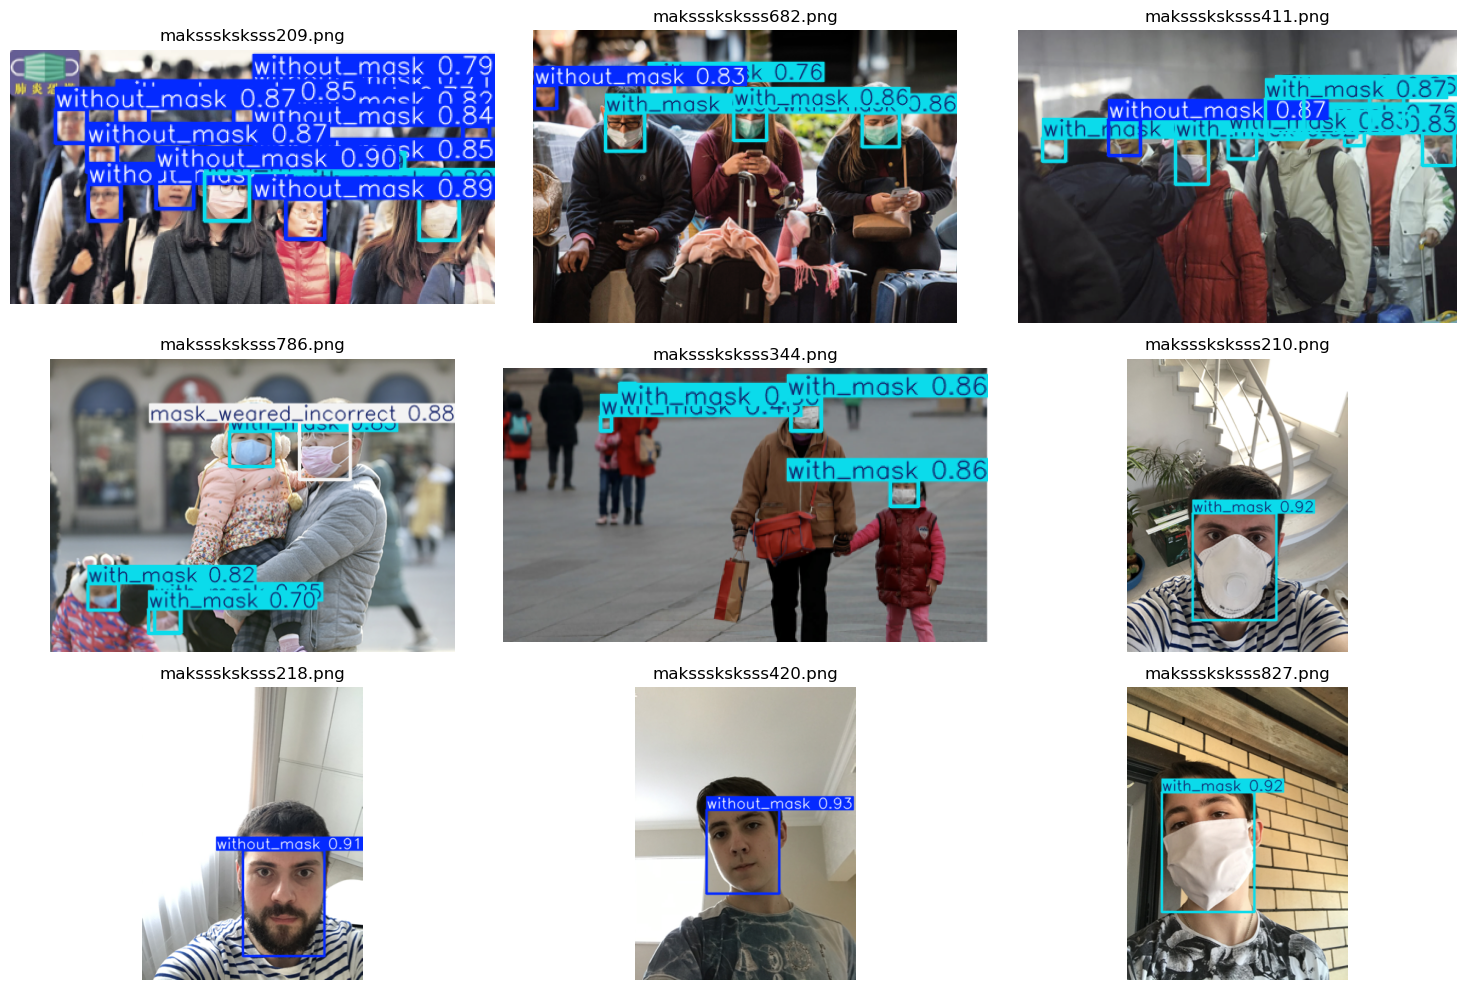

In [13]:
inference_dataset = "dataset/_stratified_dataset/val"  # Reemplaza por la ruta de tu dataset
draw_inference_grid(model, inference_dataset, grid_size=(3, 3))

Looks good! of course we are only making inference with 1 image, but the results looks promising! This needs to be done on several images to see what is the performance though!

Finally, YOLOv8 creates a folder called "runs" which stores all the fine tuning runs we do and orders them sequentially. This is good to make comparison of different trainnings if we change something.

I will only show 1 of the results images that we get that track some metrics of our model. This below is a Precision-Recall Curve graphic, in which we can see the trade-off that happens when increasing or decreasing recall over precision.


Key points:
- class without_mask is able to mantain a high recall and high accuracy even though we increase our confidence threshhold. This means that our model is quite good at detecting people without mask
- class mask_weared_incorrect is more erratic, and this is due to the fact that our model may not be good at detecting people wearing mask incorrectly... this is due to the fact that only 3% of our instances are from this class and therefor our model has low confidence in detecting such cases.

## The end!

This is only an exercise for practicing detection using YOLOv8 and understanding the procedures of training and dataset preprocess. Of course there are more steps to perform now, like analyzing the results of the training, improving the model if needed, changing data augmentation (yes, yolo does automatically data augmentation, and its parameters can be configured in the yaml file), balacing the classes using data augmentation `mosaics` and `mixups`, modifying the loss function to give more "weight" to the minor classes (this can be done using the parameter `class_weights=[2,1,2]`, for instance, in the train () method.